# QDA
Use covariance shrinkage for better QDA (Quadratic Discriminant Analysis)

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import covariance_DRO
from sklearn.covariance import LedoitWolf, EmpiricalCovariance

from warnings import warn, filterwarnings

import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, KFold

filterwarnings('ignore')

In [3]:
dataset = 'ilpd.txt'
X, y = load_svmlight_file('datasets/'+dataset)
# y are in format {-1, +1}, turn to format {0, 1}
y = (y+1)/2

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=420)
X_test = X_test.toarray()

In [5]:
p1 = y_train.mean()
p0 = 1-p1

In [6]:
from scipy.stats import multivariate_normal

In [7]:
def probability(cov1, cov2, m1, m2, p1, p2, X):
    Px1 = p1*multivariate_normal(mean=m1, cov=cov1).pdf(X)
    if np.any(np.isnan(cov2)):
        print(cov2)
    Px2 = p2*multivariate_normal(mean=m2, cov=cov2).pdf(X)
    return Px2/(Px1+Px2)

In [8]:
def evaluate_method(cov1, cov2, m1, m2, p1, p2, X):
    P = probability(cov1, cov2, m1, m2, p1, p2, X)
    print(roc_auc_score(y_test, P))
    return P

## Empirical Covariance

In [9]:
c0 = EmpiricalCovariance().fit(X_train[y_train==0].toarray())
c1 = EmpiricalCovariance().fit(X_train[y_train==1].toarray())
evaluate_method(c0.covariance_, c1.covariance_, c0.location_, c1.location_, p0, p1, X_test);

0.7422027290448342


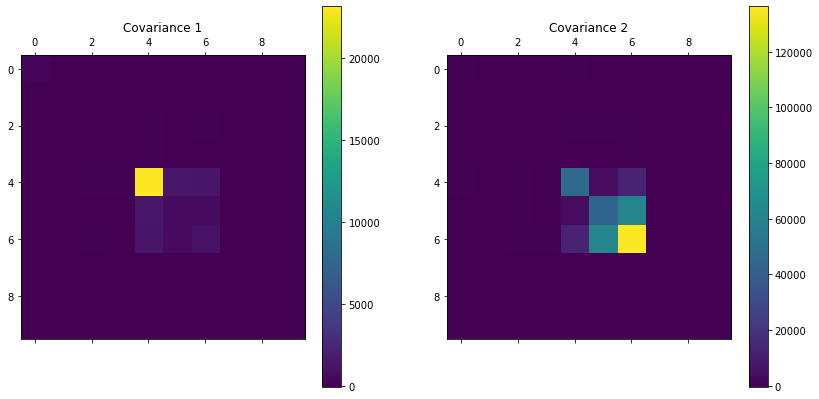

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
im1 = ax[0].matshow(c0.covariance_)
im2 = ax[1].matshow(c1.covariance_)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Covariance 1')
ax[1].set_title('Covariance 2');

## Ledoit-Wolf

In [11]:
c0 = LedoitWolf().fit(X_train[y_train==0].toarray())
c1 = LedoitWolf().fit(X_train[y_train==1].toarray())
evaluate_method(c0.covariance_, c1.covariance_, c0.location_, c1.location_, p0, p1, X_test);

0.7102826510721247


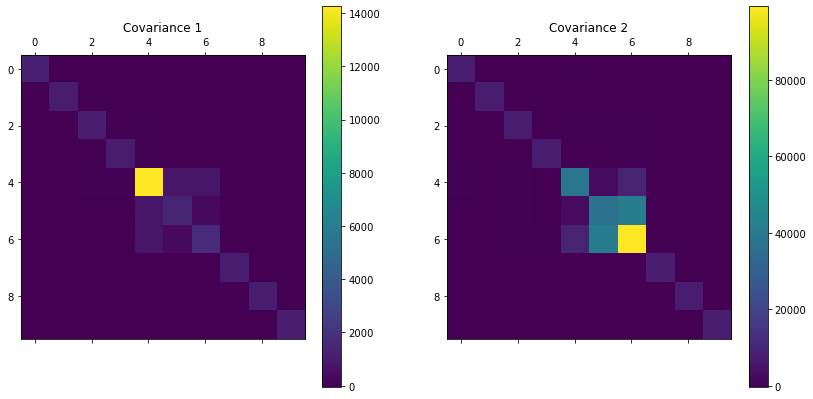

In [12]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
im1 = ax[0].matshow(c0.covariance_)
im2 = ax[1].matshow(c1.covariance_)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Covariance 1')
ax[1].set_title('Covariance 2');

## Linear Shrinkage

In [13]:
from tqdm import tqdm
def cv_linear(X, y, method, epsilon_candidates, target_func):
    best_epsilons, best_accuracy = None, -1
    for e1 in tqdm(epsilon_candidates):
        for e2 in epsilon_candidates:
            accuracies, ns = [], []
            kf = KFold(n_splits=20)
            for train_index, test_index in kf.split(X):
                train, val = X[train_index], X[test_index]
                y_train, y_val = y[train_index], y[test_index]
                # find the weight
                X1, X2 = train[y_train==0], train[y_train==1]
                c1 = EmpiricalCovariance(assume_centered=False).fit(X1)
                c2 = EmpiricalCovariance(assume_centered=False).fit(X2)
                cov1 = e1*c1.covariance_ + (1-e1)*target_func(c1.covariance_)
                cov2 = e2*c2.covariance_ + (1-e2)*target_func(c2.covariance_)
                P = probability(cov1, cov2, c1.location_, c1.location_, p0, p1, val)
                accuracies.append(roc_auc_score(y_val, np.nan_to_num(P)))
                ns.append(len(test_index))
            # keep track of best epsilon
            if (np.array(accuracies)*np.array(ns)).sum()/np.sum(ns)>best_accuracy:
                best_accuracy = (np.array(accuracies)*np.array(ns)).sum()/np.sum(ns)
                best_epsilons = (e1,e2)
    
    # warn if best epsilon is on border
    for best_epsilon in best_epsilons:
        if best_epsilon==epsilon_candidates[0]:
            print('Epsilon on left side of interval')
        if best_epsilon==epsilon_candidates[-1]:
            print('Epsilon on right side of interval')
    # return estimated covariance matrix
    X1 = X[y==0]
    X2 = X[y==1]
    c1 = EmpiricalCovariance(assume_centered=False).fit(X1)
    c2 = EmpiricalCovariance(assume_centered=False).fit(X2)
    print('Epsilon 1: {}'.format(best_epsilons[0]))
    print('Epsilon 2: {}'.format(best_epsilons[1]))
    return (best_epsilons[0]*c1.covariance_ + (1-best_epsilons[0])*target_func(c1.covariance_), 
            best_epsilons[1]*c2.covariance_ + (1-best_epsilons[1])*target_func(c2.covariance_), 
            c1.location_, 
            c2.location_)

In [14]:
c1, c2, l1, l2 = cv_linear(X_train.toarray(), y_train, 'KLdirect', np.logspace(-2, 0, 50, endpoint=False), lambda X: np.diag(np.diag(X)))
Pld = evaluate_method(c1, c2, l1, l2, p0, p1, X_test)

100%|██████████| 50/50 [01:59<00:00,  2.39s/it]

Epsilon on right side of interval
Epsilon 1: 0.5248074602497725
Epsilon 2: 0.9120108393559097
0.7456140350877194


In [15]:
c1, c2, l1, l2 = cv_linear(X_train.toarray(), y_train, 'KLdirect', np.logspace(-3, 0, 50, endpoint=False), lambda X: np.eye(X.shape[0])*np.trace(X)/X.shape[0])
Pl = evaluate_method(c1, c2, l1, l2, p0, p1, X_test)

100%|██████████| 50/50 [01:58<00:00,  2.38s/it]

Epsilon 1: 0.3311311214825911
Epsilon 2: 0.1096478196143185
0.7258771929824561


## Ours

In [16]:
from tqdm import tqdm

In [17]:
def cv(X, y, method, epsilon_candidates):
    best_epsilons, best_accuracy = None, -1
    for e1 in tqdm(epsilon_candidates):
        for e2 in epsilon_candidates:
            accuracies, ns = [], []
            kf = KFold(n_splits=20)
            for train_index, test_index in kf.split(X):
                train, val = X[train_index], X[test_index]
                y_train, y_val = y[train_index], y[test_index]
                # find the weight
                X1, X2 = train[y_train==0], train[y_train==1]
                c1 = EmpiricalCovariance(assume_centered=False).fit(X1)
                c2 = EmpiricalCovariance(assume_centered=False).fit(X2)
                cov1 = covariance_DRO.estimate_cov(c1.covariance_, e1, method)
                cov2 = covariance_DRO.estimate_cov(c2.covariance_, e2, method)
                P = probability(cov1, cov2, c1.location_, c1.location_, p0, p1, val)
                accuracies.append(roc_auc_score(y_val, np.nan_to_num(P)))
                ns.append(len(test_index))
            # keep track of best epsilon
            if (np.array(accuracies)*np.array(ns)).sum()/np.sum(ns)>best_accuracy:
                best_accuracy = (np.array(accuracies)*np.array(ns)).sum()/np.sum(ns)
                best_epsilons = (e1,e2)
    
    # warn if best epsilon is on border
    for best_epsilon in best_epsilons:
        if best_epsilon==epsilon_candidates[0]:
            print('Epsilon on left side of interval')
        if best_epsilon==epsilon_candidates[-1]:
            print('Epsilon on right side of interval')
    # return estimated covariance matrix
    X1 = X[y==0]
    X2 = X[y==1]
    c1 = EmpiricalCovariance(assume_centered=False).fit(X1)
    c2 = EmpiricalCovariance(assume_centered=False).fit(X2)
    print('Epsilon 1: {}'.format(best_epsilons[0]))
    print('Epsilon 2: {}'.format(best_epsilons[1]))
    return (covariance_DRO.estimate_cov(c1.covariance_, best_epsilons[0], method), 
            covariance_DRO.estimate_cov(c2.covariance_, best_epsilons[1], method), 
            c1.location_, 
            c2.location_)

In [18]:
c1, c2, l1, l2 = cv(X_train.toarray(), y_train, 'KLdirect', np.logspace(-1,3,50))
Pk = evaluate_method(c1, c2, l1, l2, p0, p1, X_test)

100%|██████████| 50/50 [03:43<00:00,  4.47s/it]

Epsilon on left side of interval
Epsilon 1: 0.5428675439323859
Epsilon 2: 0.1
0.7517056530214424


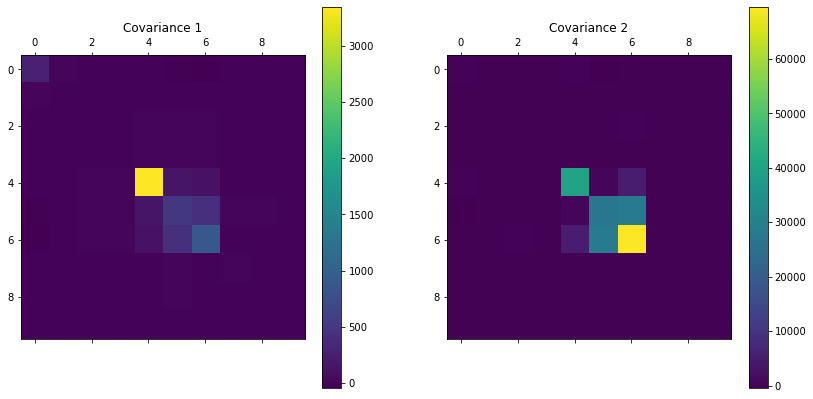

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
im1 = ax[0].matshow(c1)
im2 = ax[1].matshow(c2)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Covariance 1')
ax[1].set_title('Covariance 2');

In [20]:
c1, c2, l1, l2 = cv(X_train.toarray(), y_train, 'Wasserstein', np.logspace(-2,3,50))
Pw = evaluate_method(c1, c2, l1, l2, p0, p1, X_test)

100%|██████████| 50/50 [04:02<00:00,  4.85s/it]

Epsilon 1: 75.43120063354623
Epsilon 2: 59.63623316594643
0.7502436647173489


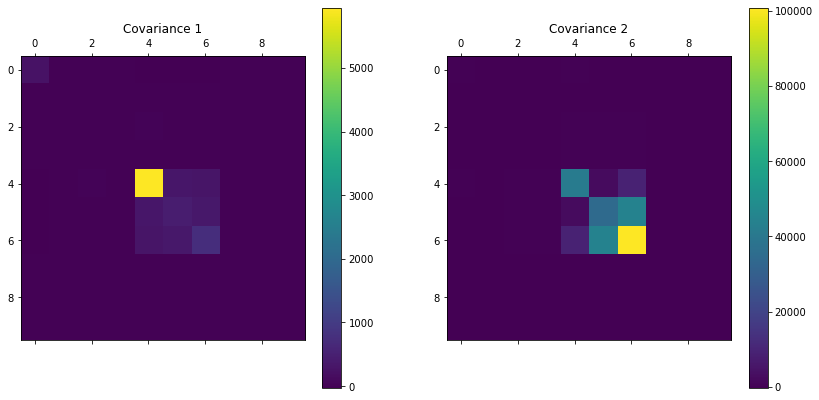

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
im1 = ax[0].matshow(c1)
im2 = ax[1].matshow(c2)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Covariance 1')
ax[1].set_title('Covariance 2');

In [22]:
c1, c2, l1, l2 = cv(X_train.toarray(), y_train, 'Fisher-Rao', np.logspace(-2,3,50))
Pf = evaluate_method(c1, c2, l1, l2, p0, p1, X_test)

100%|██████████| 50/50 [5:53:55<00:00, 424.71s/it]  

Epsilon 1: 1.757510624854793
Epsilon 2: 0.8685113737513529
0.7524366471734892


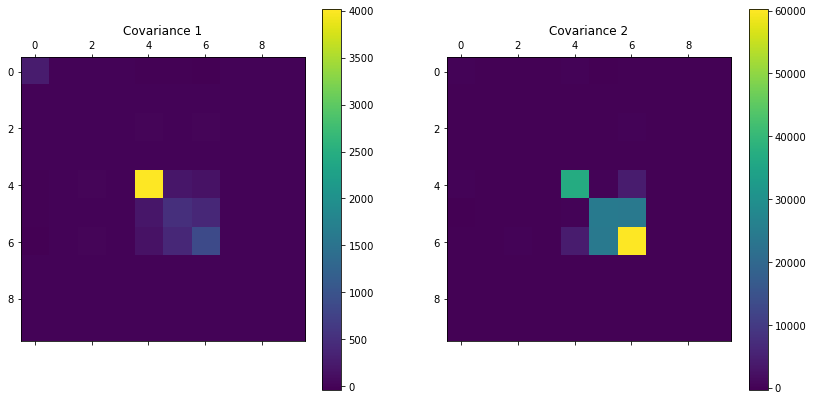

In [23]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
im1 = ax[0].matshow(c1)
im2 = ax[1].matshow(c2)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Covariance 1')
ax[1].set_title('Covariance 2');